## Install required libraries

In [ ]:
!pip install matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

## Import required libraries

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

## Change settings

In [11]:
# Warning display off
import warnings
warnings.simplefilter('ignore')

# Change default font size
plt.rcParams['font.size'] = 14

# Change default graph size
plt.rcParams['figure.figsize'] = (6,6)

# Square indicate ON
plt.rcParams['axes.grid'] = True

# Set precision of floating-point numbers in numpy
np.set_printoptions(suppress=True, precision=5)

## GPU utilization

In [12]:
# Allocate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Prepare for the dataset

In [13]:
import torchvision.datasets as datasets

# Directory name for the download
data_root = './data'

train_set0 = datasets.MNIST(
    # Specify the download destination
    root = data_root,

    # Training data
    train = True,

    # Download when the original data is unavailable
    download = True)

## Data preprocessing using Transforms

In [14]:
# Loading by dataset
import torchvision.transforms as transforms

transform = transforms.Compose([
    # Data Tensorization
    transforms.ToTensor(),

    # Data normalization
    # Although the dataset is already normalized, we change the data range to
    # [-1, 1] to increase the model accuracy
    transforms.Normalize(0.5, 0.5),

    # Convert to first-order tensor (Convert the data shape from [1, 28, 28] to [784])
    transforms.Lambda(lambda x: x.view(-1)),
])

In [15]:
# Definition of the training dataset
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform)

# Definition of the verification dataset
test_set = datasets.MNIST(
    root = data_root, train = False,
    download = True, transform = transform)

## Data generation for mini-batches using the DataLoader

In [16]:
from torch.utils.data import DataLoader

# Minibatch size specification
batch_size = 500

# Training Data Loader (Since it's for training, shuffle the data)
train_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True)

# Data Loader for Validation (Shuffling is not required during validation)
test_loader = DataLoader(
    test_set,  batch_size = batch_size,
    shuffle = False)

In [ ]:
# The number of datasets
print(len(train_loader))

# Retrieve the first set from DataLoader
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

In [ ]:
# Display image
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)

    # Convert to numpy
    image = images[i].numpy()
    label = labels[i]

    # Reset the image range to [0, 1]
    image2 = (image + 1)/ 2

    # Display the image
    plt.imshow(image2.reshape(28, 28),cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Define the class of the prediction model

In [17]:
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # Definition of hidden layer
        self.l1 = nn.Linear(n_input, n_hidden)

        # Definition of output layer
        self.l2 = nn.Linear(n_hidden, n_output)

        # Definition of ReLU function
        self.relu = nn.ReLU(inplace=True)

    # Difine the prediction function
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

## Prepare for the calculation

In [21]:
# Dimension of input
n_input = image.shape[0]

# Dimension of output
n_output = 10

# Number of hidden layer nodes
n_hidden = 128

In [22]:
# Learning rate
lr = 0.01

# Random number fixing
# Due to the enormous number of model parameters, setting all element values to
# 1.0 prevents learning
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# Create predict function
net = Net(n_input, n_output, n_hidden)

# Send the model to the GPU
net = net.to(device)

# Create loss function
criterion = nn.CrossEntropyLoss()

# Create Optimization function
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# Repetition counts
num_epochs = 100

# Record evaluation results
history = np.zeros((0,5))

## Execute digit recognition

In [ ]:
# To show a progress bar, we import tqdm
from tqdm.notebook import tqdm

for epoch in range(num_epochs):
    # Number of correct answers per epoch (for accuracy calculation)
    n_train_acc, n_val_acc = 0, 0

    # Cumulative loss per epoch (before averaging)
    train_loss, val_loss = 0, 0

    # Number of cumulative data records per epoch
    n_train, n_test = 0, 0


    # Training phase
    for inputs, labels in tqdm(train_loader):
        # Number of data records per batch
        train_batch_size = len(labels)

        # Number of data records accumulated per epoch
        n_train += train_batch_size

        # Transfer to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Initialize gradient
        optimizer.zero_grad()

        # 1. Calculate prediction
        outputs = net(inputs)

        # 2. Calculate loss
        loss = criterion(outputs, labels)

        # 3. Calculate gradient
        loss.backward()

        # 4. Adjust parameters
        optimizer.step()

        # Calculate the prediction label
        predicted = torch.max(outputs, 1)[1]

        # Calculate loss
        # Since the loss is calculated as an average, revert it to
        # the pre-averaging loss and add it back
        train_loss += loss.item() * train_batch_size

        # Calculate accuracy
        n_train_acc += (predicted == labels).sum().item()


    # Prediction phase
    for inputs_test, labels_test in test_loader:
        # Number of data records per batch
        test_batch_size = len(labels_test)

        # Number of data records accumulated per epoch
        n_test += test_batch_size

        # Transfer to GPU
        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 1. Calculate prediction
        outputs_test = net(inputs_test)

        # 2. Calculate loss
        loss_test = criterion(outputs_test, labels_test)

        # Calculate the prediction label
        predicted_test = torch.max(outputs_test, 1)[1]

        # Calculate loss
        # Since the loss is calculated as an average, revert it to
        # the pre-averaging loss and add it back
        val_loss +=  loss_test.item() * test_batch_size

        # Calculate accuracy
        n_val_acc +=  (predicted_test == labels_test).sum().item()

    # Calculate the accuracy of the training and the validation
    train_acc = n_train_acc / n_train
    val_acc = n_val_acc / n_test

    # Calculate the loss of the training and the validation
    ave_train_loss = train_loss / n_train
    ave_val_loss = val_loss / n_test

    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {ave_train_loss:.5f} acc: {train_acc:.5f} val_loss: {ave_val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , ave_train_loss, train_acc, ave_val_loss, val_acc])
    history = np.vstack((history, item))

## Confirm the loss values and accuracies

In [24]:
print(f'Initial: Loss: {history[0,3]:.5f} Accuracy: {history[0,4]:.5f}' )
print(f'Final: Loss: {history[-1,3]:.5f} Accuracy: {history[-1,4]:.5f}' )

Initial: Loss: 1.32629 Accuracy: 0.74660
Final: Loss: 0.17067 Accuracy: 0.94960


## Display the learning curve for the loss

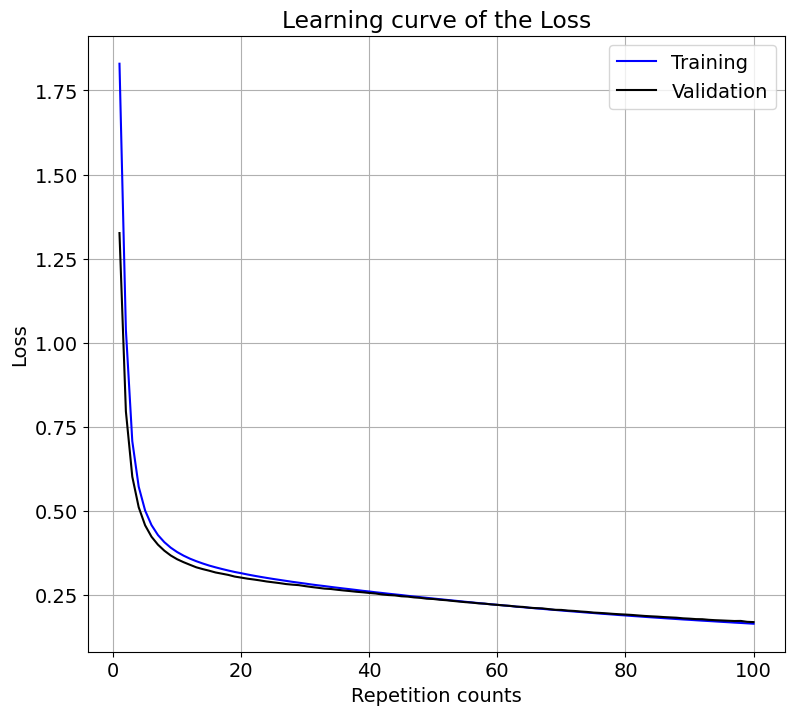

In [25]:
plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,1], 'b', label='Training')
plt.plot(history[:,0], history[:,3], 'k', label='Validation')
plt.xlabel('Repetition counts')
plt.ylabel('Loss')
plt.title('Learning curve of the Loss')
plt.legend()
plt.show()

## Display learning curve for the accuracy

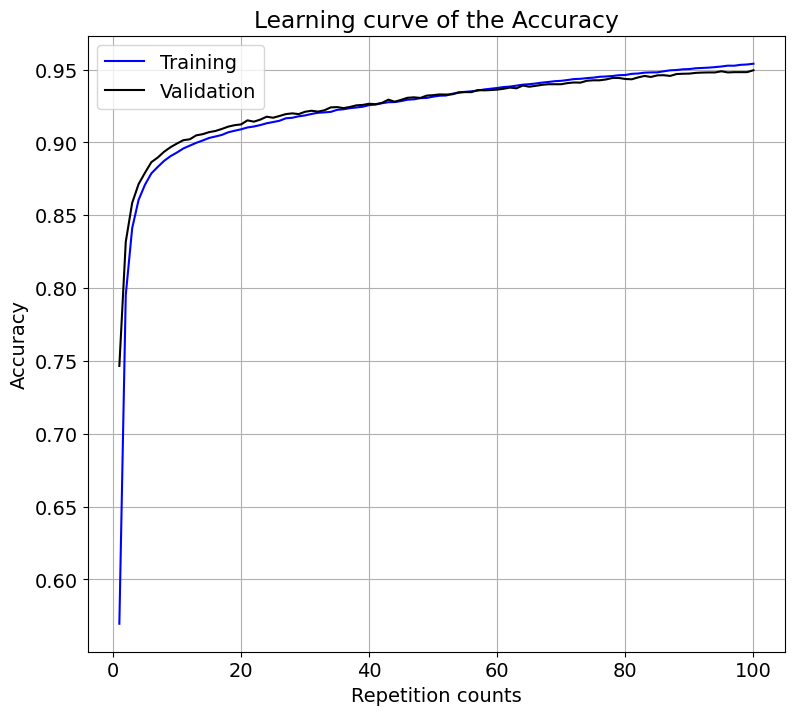

In [26]:
plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,2], 'b', label='Training')
plt.plot(history[:,0], history[:,4], 'k', label='Validation')
plt.xlabel('Repetition counts')
plt.ylabel('Accuracy')
plt.title('Learning curve of the Accuracy')
plt.legend()
plt.show()